In [59]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [60]:
import numpy as np
pi = np.pi
%matplotlib notebook
import matplotlib.pyplot as plt

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [61]:
l = 1.0   # length in pixels
g = 1.0    # gravity in m/s**2
m = 1.0    # mass in kg
b = 1.0    # damping
u_constraint = 0.5 # input constraint

x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P_size = 3
P = Variable(torch.FloatTensor([1, 1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    monomials = Variable(torch.zeros(P_size))
    monomials[0] = x[1].pow(2)
    monomials[1] = torch.cos(x[0])
    monomials[2] = 1
    polynomial = torch.dot(P, monomials)
    return polynomial.pow(2)

def compute_V_energy_based(x):
    '''V(x) = (E - E_d)^2'''
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    difference_squared = (energy-energy_desired).pow(2)
    return difference_squared

print x_i.shape
print "V is", compute_V(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print "V is", compute_V(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    monomials = Variable(torch.zeros(K_size, x.shape[1]))
    monomials[0] = x[1,:].pow(2)
    monomials[1] = torch.cos(x[0,:])
    monomials[2] = 1
    P_transpose = torch.t(P.unsqueeze(1))
    polynomial = P_transpose.mm(monomials)
    return polynomial.pow(2)

def compute_V_energy_based_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:].pow(2) + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    difference_squared = (energy_vectorized-energy_desired).pow(2)
    return difference_squared
    
print many_x_i
print compute_V_energy_based_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
 1
[torch.FloatTensor of size 3]

torch.Size([2])
V is Variable containing:
 7.5642
[torch.FloatTensor of size 1]

V is Variable containing:
 39.6094
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 0.0211
 3.5104
 9.5102
[torch.FloatTensor of size 3]



In [63]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
# K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
# print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot

def pendulum_policy(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    return -torch.dot(K,x-x_desired)

def pendulum_energy_policy(x):
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    return -1*x[1]*(energy - energy_desired)

K_size = 3
#K = torch.randn(K_size)
#K = Variable(K, requires_grad=True)
K = Variable(torch.FloatTensor([0.5*m*l**2, m*g*l, -m*g*l]).type(dtype), requires_grad=True)
def pendulum_policy_search(x):
    monomials = Variable(torch.zeros(K_size))
    monomials[0] = x[1].pow(3)
    monomials[1] = x[1]*torch.cos(x[0])
    monomials[2] = x[1]
    u = -torch.dot(K, monomials)
    return u.clamp(min=u_constraint).clamp(max=u_constraint)

def pendulum_dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    u = pendulum_policy_search(x)
    xdot[1] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
    
xdot = pendulum_dynamics(x_i)
print xdot
print pendulum_dynamics(x_i_2)
print "policy search is", pendulum_policy_search(x_i)
print "policy search is", pendulum_policy_search(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot

def pendulum_policy_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    K_transpose = torch.t(K.unsqueeze(1))
    return K_transpose.mm(x - x_desired_vectorized)

def pendulum_energy_policy_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:]**2 + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    return -K[0]*x[1,:]*(energy_vectorized - energy_desired)

def pendulum_policy_search_vectorized(x):
    monomials = Variable(torch.zeros(K_size, x.shape[1]))
    monomials[0] = x[1,:].pow(3)
    monomials[1] = x[1,:]*torch.cos(x[0,:])
    monomials[2] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    return (-K_transpose.mm(monomials)).clamp(min=-u_constraint).clamp(max=u_constraint)

def pendulum_dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    u = pendulum_policy_search_vectorized(x)
    xdot[1,:] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
      
print many_x_i
print pendulum_dynamics_vectorized(many_x_i)
print "policy search is", pendulum_policy_search_vectorized(many_x_i)

Variable containing:
 1.1000
 1.3415
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
 1.3912
[torch.FloatTensor of size 2]

policy search is Variable containing:
 0.5000
[torch.FloatTensor of size 1]

policy search is Variable containing:
 0.5000
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 1.1000  2.2000  3.0000
 0.6816  0.3912  0.4093
[torch.FloatTensor of size 2x3]

policy search is Variable containing:
-0.1598 -0.5000 -0.5000
[torch.FloatTensor of size 1x3]



In [64]:
## COMPARE ENERGY POLICY

print "energy computes", pendulum_energy_policy(x_i)
print "search computes", pendulum_policy_search(x_i)

energy computes Variable containing:
-0.1598
[torch.FloatTensor of size 1]

search computes Variable containing:
 0.5000
[torch.FloatTensor of size 1]



In [65]:
def compute_Vdot(x):
    V = compute_V(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print "Vdot_vec is", Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
 11.1421
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Vdot_vec is Variable containing:
 3.1573
-3.0127
-5.2157
[torch.FloatTensor of size 3]

Variable containing:
 3.1573
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [66]:
#K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
#P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        print i
        print compute_V(x_i)
        print Vdot.data[0]
        break

false, counterexample found:  Variable containing:
 0.7921
 0.2047
[torch.FloatTensor of size 2]

0
Variable containing:
 3.0425
[torch.FloatTensor of size 1]

1.22249996662


## Now let's search for K, from an initialization not stable

In [67]:
P = Variable(torch.rand(3).type(dtype), requires_grad=True)
K = Variable(torch.randn(3).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.2102
 0.1877
 0.2417
[torch.FloatTensor of size 3]

Initial K Variable containing:
-0.6425
-0.1031
 0.2404
[torch.FloatTensor of size 3]

false, counterexample found:  Variable containing:
 0.0509
 1.5156
[torch.FloatTensor of size 2]



In [99]:
# Reset 
P = Variable(torch.rand(3).type(dtype), requires_grad=True)
K = Variable(torch.randn(3).type(dtype), requires_grad=True)

In [100]:
P.data = P.data/(abs(P.data.sum()))

In [107]:
print P
print K

Variable containing:
1.00000e-04 *
 -0.4910
 -8.6998
  6.6812
[torch.FloatTensor of size 3]

Variable containing:
 0.9489
-0.4682
-0.5841
[torch.FloatTensor of size 3]



<IPython.core.display.Javascript object>


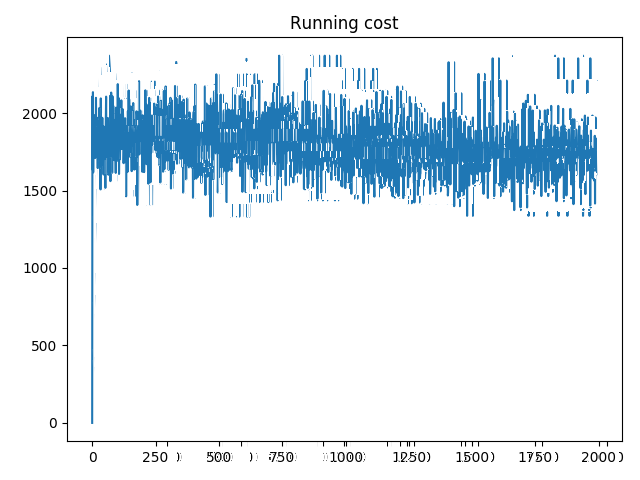

In [108]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [109]:
## optimize

num_iterations = 2000
num_samples_per_iteration = 1000
step_rate = 1e-5
slack_var = .01

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    samples = torch.randn(2,num_samples_per_iteration).type(dtype)
    many_x_i = Variable(samples, requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=-slack_var).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    #P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    P.data = P.data/(abs(P.data.sum()))
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K
    
    if cost_iteration == num_iterations - 1:
        print "didn't converge"

first P is Variable containing:
1.00000e-04 *
 -0.4910
 -8.6998
  6.6812
[torch.FloatTensor of size 3]

first K is Variable containing:
 0.9489
-0.4682
-0.5841
[torch.FloatTensor of size 3]

0.00284504890442 is time for one step of grad descent

-2.70008308689e-06
P is Variable containing:
-0.1931
-3.4662
 2.6593
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9489
-0.4682
-0.5841
[torch.FloatTensor of size 3]

0.00274395942688 is time for one step of grad descent

2107.2019043
P is Variable containing:
-0.1948
-3.4588
 2.6536
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9490
-0.4677
-0.5841
[torch.FloatTensor of size 3]

0.00243496894836 is time for one step of grad descent

1633.59533691
P is Variable containing:
-0.1938
-3.4704
 2.6642
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9491
-0.4672
-0.5842
[torch.FloatTensor of size 3]

0.00228095054626 is time for one step of grad descent

2134.80786133
P is Variable containing:
-0.1953
-3.4579
 

P is Variable containing:
-0.1961
-3.4568
 2.6529
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9498
-0.4440
-0.5926
[torch.FloatTensor of size 3]

0.00188493728638 is time for one step of grad descent

1738.8458252
P is Variable containing:
-0.1965
-3.4586
 2.6551
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9500
-0.4436
-0.5926
[torch.FloatTensor of size 3]

0.00148916244507 is time for one step of grad descent

1516.8828125
P is Variable containing:
-0.1966
-3.4581
 2.6548
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9500
-0.4431
-0.5927
[torch.FloatTensor of size 3]

0.00143194198608 is time for one step of grad descent

1847.49938965
P is Variable containing:
-0.1973
-3.4583
 2.6556
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9500
-0.4426
-0.5929
[torch.FloatTensor of size 3]

0.00133085250854 is time for one step of grad descent

1998.27636719
P is Variable containing:
-0.1976
-3.4600
 2.6576
[torch.FloatTensor of size 3

K is Variable containing:
 0.9482
-0.4113
-0.6062
[torch.FloatTensor of size 3]

0.00201511383057 is time for one step of grad descent

1970.41918945
P is Variable containing:
-0.1958
-3.4807
 2.6766
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9482
-0.4108
-0.6065
[torch.FloatTensor of size 3]

0.00177597999573 is time for one step of grad descent

1809.10351562
P is Variable containing:
-0.1968
-3.4736
 2.6704
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9481
-0.4104
-0.6067
[torch.FloatTensor of size 3]

0.00185799598694 is time for one step of grad descent

1839.8079834
P is Variable containing:
-0.1955
-3.4794
 2.6749
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9481
-0.4099
-0.6070
[torch.FloatTensor of size 3]

0.00168609619141 is time for one step of grad descent

2012.00463867
P is Variable containing:
-0.1956
-3.4790
 2.6746
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9480
-0.4095
-0.6073
[torch.FloatTensor of size 

0.00369501113892 is time for one step of grad descent

1904.51940918
P is Variable containing:
-0.1939
-3.4548
 2.6486
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9455
-0.3825
-0.6199
[torch.FloatTensor of size 3]

0.00225782394409 is time for one step of grad descent

2011.1307373
P is Variable containing:
-0.1944
-3.4503
 2.6448
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9453
-0.3819
-0.6203
[torch.FloatTensor of size 3]

0.00213003158569 is time for one step of grad descent

1985.12988281
P is Variable containing:
-0.1946
-3.4427
 2.6373
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9451
-0.3815
-0.6207
[torch.FloatTensor of size 3]

0.00218105316162 is time for one step of grad descent

1851.94763184
P is Variable containing:
-0.1938
-3.4482
 2.6421
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9448
-0.3811
-0.6212
[torch.FloatTensor of size 3]

0.00197792053223 is time for one step of grad descent

1406.66394043
P is Var

P is Variable containing:
-0.1890
-3.4998
 2.6888
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9415
-0.3515
-0.6352
[torch.FloatTensor of size 3]

0.00159907341003 is time for one step of grad descent

1943.73779297
P is Variable containing:
-0.1904
-3.4924
 2.6827
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9413
-0.3509
-0.6356
[torch.FloatTensor of size 3]

0.00145196914673 is time for one step of grad descent

1879.42248535
P is Variable containing:
-0.1902
-3.4901
 2.6803
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9413
-0.3504
-0.6358
[torch.FloatTensor of size 3]

0.00144505500793 is time for one step of grad descent

1866.0435791
P is Variable containing:
-0.1897
-3.4892
 2.6789
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9413
-0.3500
-0.6359
[torch.FloatTensor of size 3]

0.00150108337402 is time for one step of grad descent

1819.5904541
P is Variable containing:
-0.1893
-3.4852
 2.6745
[torch.FloatTensor of size 3

P is Variable containing:
-0.1858
-3.4792
 2.6650
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9384
-0.3326
-0.6455
[torch.FloatTensor of size 3]

0.00147700309753 is time for one step of grad descent

1660.59570312
P is Variable containing:
-0.1880
-3.4687
 2.6567
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9384
-0.3321
-0.6456
[torch.FloatTensor of size 3]

0.00123405456543 is time for one step of grad descent

1971.81445312
P is Variable containing:
-0.1887
-3.4594
 2.6481
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9383
-0.3316
-0.6459
[torch.FloatTensor of size 3]

0.00121903419495 is time for one step of grad descent

2142.30151367
P is Variable containing:
-0.1938
-3.4286
 2.6223
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9381
-0.3312
-0.6462
[torch.FloatTensor of size 3]

0.0012309551239 is time for one step of grad descent

1836.75036621
P is Variable containing:
-0.1927
-3.4312
 2.6239
[torch.FloatTensor of size 

P is Variable containing:
-0.1899
-3.4805
 2.6703
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9354
-0.3129
-0.6552
[torch.FloatTensor of size 3]

0.00188779830933 is time for one step of grad descent

1634.80908203
P is Variable containing:
-0.1908
-3.4758
 2.6666
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9353
-0.3126
-0.6555
[torch.FloatTensor of size 3]

0.00167107582092 is time for one step of grad descent

1784.45654297
P is Variable containing:
-0.1930
-3.4652
 2.6583
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9351
-0.3121
-0.6558
[torch.FloatTensor of size 3]

0.00146889686584 is time for one step of grad descent

1958.22387695
P is Variable containing:
-0.1960
-3.4458
 2.6418
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9350
-0.3116
-0.6561
[torch.FloatTensor of size 3]

0.00144505500793 is time for one step of grad descent

1849.55871582
P is Variable containing:
-0.1968
-3.4456
 2.6424
[torch.FloatTensor of size

P is Variable containing:
-0.1912
-3.4797
 2.6709
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9307
-0.2938
-0.6668
[torch.FloatTensor of size 3]

0.00186109542847 is time for one step of grad descent

2086.5612793
P is Variable containing:
-0.1937
-3.4642
 2.6579
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9306
-0.2934
-0.6671
[torch.FloatTensor of size 3]

0.00144910812378 is time for one step of grad descent

1995.00915527
P is Variable containing:
-0.1951
-3.4595
 2.6546
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9306
-0.2928
-0.6673
[torch.FloatTensor of size 3]

0.00151610374451 is time for one step of grad descent

1769.24047852
P is Variable containing:
-0.1951
-3.4629
 2.6580
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9307
-0.2922
-0.6673
[torch.FloatTensor of size 3]

0.00138592720032 is time for one step of grad descent

1988.45422363
P is Variable containing:
-0.1950
-3.4641
 2.6591
[torch.FloatTensor of size 

P is Variable containing:
-0.1983
-3.4726
 2.6709
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9267
-0.2738
-0.6779
[torch.FloatTensor of size 3]

0.00174999237061 is time for one step of grad descent

2007.84399414
P is Variable containing:
-0.1995
-3.4605
 2.6600
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9266
-0.2733
-0.6782
[torch.FloatTensor of size 3]

0.00133013725281 is time for one step of grad descent

1712.56481934
P is Variable containing:
-0.2013
-3.4495
 2.6509
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9264
-0.2729
-0.6786
[torch.FloatTensor of size 3]

0.00146293640137 is time for one step of grad descent

1574.73510742
P is Variable containing:
-0.2016
-3.4529
 2.6545
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9263
-0.2724
-0.6789
[torch.FloatTensor of size 3]

0.00121784210205 is time for one step of grad descent

2044.7166748
P is Variable containing:
-0.2011
-3.4484
 2.6495
[torch.FloatTensor of size 

0.00277805328369 is time for one step of grad descent

1624.42126465
P is Variable containing:
-0.2024
-3.4679
 2.6703
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9212
-0.2528
-0.6908
[torch.FloatTensor of size 3]

0.00132608413696 is time for one step of grad descent

1924.46032715
P is Variable containing:
-0.2026
-3.4693
 2.6719
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9211
-0.2521
-0.6911
[torch.FloatTensor of size 3]

0.00122094154358 is time for one step of grad descent

1773.25964355
P is Variable containing:
-0.2021
-3.4770
 2.6791
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9212
-0.2515
-0.6912
[torch.FloatTensor of size 3]

0.00121998786926 is time for one step of grad descent

2171.8762207
P is Variable containing:
-0.2026
-3.4700
 2.6726
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9211
-0.2509
-0.6916
[torch.FloatTensor of size 3]

0.00126099586487 is time for one step of grad descent

1846.72363281
P is Var

P is Variable containing:
-0.1928
-3.4900
 2.6828
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9159
-0.2331
-0.7030
[torch.FloatTensor of size 3]

0.00175499916077 is time for one step of grad descent

2138.83056641
P is Variable containing:
-0.1944
-3.4788
 2.6732
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9157
-0.2327
-0.7035
[torch.FloatTensor of size 3]

0.00139617919922 is time for one step of grad descent

1782.21569824
P is Variable containing:
-0.1930
-3.4922
 2.6852
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9158
-0.2323
-0.7035
[torch.FloatTensor of size 3]

0.00144720077515 is time for one step of grad descent

1766.97290039
P is Variable containing:
-0.1922
-3.4906
 2.6827
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9156
-0.2319
-0.7039
[torch.FloatTensor of size 3]

0.0014271736145 is time for one step of grad descent

1985.05419922
P is Variable containing:
-0.1899
-3.5088
 2.6988
[torch.FloatTensor of size 

P is Variable containing:
-0.1959
-3.4769
 2.6728
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9103
-0.2136
-0.7151
[torch.FloatTensor of size 3]

0.00260806083679 is time for one step of grad descent

1705.52685547
P is Variable containing:
-0.1955
-3.4843
 2.6798
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9103
-0.2132
-0.7153
[torch.FloatTensor of size 3]

0.00228309631348 is time for one step of grad descent

1797.06481934
P is Variable containing:
-0.1951
-3.4876
 2.6827
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9101
-0.2126
-0.7156
[torch.FloatTensor of size 3]

0.00220704078674 is time for one step of grad descent

1953.93212891
P is Variable containing:
-0.1922
-3.4983
 2.6905
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9099
-0.2121
-0.7160
[torch.FloatTensor of size 3]

0.00209999084473 is time for one step of grad descent

1627.28820801
P is Variable containing:
-0.1919
-3.5005
 2.6923
[torch.FloatTensor of size

0.00306296348572 is time for one step of grad descent

1814.43945312
P is Variable containing:
-0.1962
-3.4778
 2.6740
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9046
-0.1953
-0.7266
[torch.FloatTensor of size 3]

0.00199604034424 is time for one step of grad descent

1904.62304688
P is Variable containing:
-0.1962
-3.4817
 2.6778
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9044
-0.1947
-0.7270
[torch.FloatTensor of size 3]

0.00184297561646 is time for one step of grad descent

1835.51879883
P is Variable containing:
-0.1947
-3.4875
 2.6822
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9043
-0.1943
-0.7273
[torch.FloatTensor of size 3]

0.00186610221863 is time for one step of grad descent

1715.07189941
P is Variable containing:
-0.1946
-3.4860
 2.6806
[torch.FloatTensor of size 3]

K is Variable containing:
 0.9042
-0.1939
-0.7276
[torch.FloatTensor of size 3]

0.00204181671143 is time for one step of grad descent

1856.67163086
P is Va

K is Variable containing:
 0.8909
-0.1606
-0.7514
[torch.FloatTensor of size 3]

0.00387811660767 is time for one step of grad descent

1937.62451172
P is Variable containing:
-0.2030
-3.4630
 2.6660
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8906
-0.1602
-0.7519
[torch.FloatTensor of size 3]

0.00263714790344 is time for one step of grad descent

1638.62036133
P is Variable containing:
-0.2017
-3.4663
 2.6680
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8906
-0.1597
-0.7520
[torch.FloatTensor of size 3]

0.00211405754089 is time for one step of grad descent

1786.37646484
P is Variable containing:
-0.2010
-3.4747
 2.6757
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8905
-0.1591
-0.7522
[torch.FloatTensor of size 3]

0.00228190422058 is time for one step of grad descent

2102.20849609
P is Variable containing:
-0.2021
-3.4673
 2.6694
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8901
-0.1585
-0.7528
[torch.FloatTensor of size

0.00424695014954 is time for one step of grad descent

1786.88574219
P is Variable containing:
-0.1976
-3.4511
 2.6487
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8761
-0.1282
-0.7756
[torch.FloatTensor of size 3]

0.00213599205017 is time for one step of grad descent

2021.59680176
P is Variable containing:
-0.1997
-3.4405
 2.6402
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8760
-0.1277
-0.7758
[torch.FloatTensor of size 3]

0.00208592414856 is time for one step of grad descent

1623.44140625
P is Variable containing:
-0.1969
-3.4594
 2.6564
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8758
-0.1271
-0.7762
[torch.FloatTensor of size 3]

0.00253701210022 is time for one step of grad descent

1918.22753906
P is Variable containing:
-0.1971
-3.4572
 2.6544
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8756
-0.1265
-0.7765
[torch.FloatTensor of size 3]

0.0023500919342 is time for one step of grad descent

1535.13244629
P is Var

K is Variable containing:
 0.8568
-0.0911
-0.8047
[torch.FloatTensor of size 3]

0.00242900848389 is time for one step of grad descent

1739.35510254
P is Variable containing:
-0.1910
-3.4613
 2.6523
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8568
-0.0905
-0.8049
[torch.FloatTensor of size 3]

0.00196313858032 is time for one step of grad descent

2021.07739258
P is Variable containing:
-0.1942
-3.4413
 2.6355
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8563
-0.0900
-0.8056
[torch.FloatTensor of size 3]

0.0020580291748 is time for one step of grad descent

1758.56323242
P is Variable containing:
-0.1924
-3.4449
 2.6372
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8559
-0.0896
-0.8060
[torch.FloatTensor of size 3]

0.00174903869629 is time for one step of grad descent

1873.33728027
P is Variable containing:
-0.1911
-3.4519
 2.6430
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8555
-0.0891
-0.8066
[torch.FloatTensor of size 

P is Variable containing:
-0.1949
-3.4401
 2.6350
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8372
-0.0548
-0.8329
[torch.FloatTensor of size 3]

0.00255990028381 is time for one step of grad descent

1919.79382324
P is Variable containing:
-0.1953
-3.4358
 2.6311
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8369
-0.0543
-0.8334
[torch.FloatTensor of size 3]

0.00190210342407 is time for one step of grad descent

1608.78088379
P is Variable containing:
-0.1958
-3.4257
 2.6215
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8366
-0.0538
-0.8338
[torch.FloatTensor of size 3]

0.0018949508667 is time for one step of grad descent

1627.74560547
P is Variable containing:
-0.1948
-3.4369
 2.6317
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8364
-0.0532
-0.8342
[torch.FloatTensor of size 3]

0.00215411186218 is time for one step of grad descent

1879.32434082
P is Variable containing:
-0.1951
-3.4380
 2.6332
[torch.FloatTensor of size 

0.0038800239563 is time for one step of grad descent

2009.59155273
P is Variable containing:
-0.1926
-3.4493
 2.6419
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8241
-0.0329
-0.8502
[torch.FloatTensor of size 3]

0.00198197364807 is time for one step of grad descent

1645.79138184
P is Variable containing:
-0.1934
-3.4411
 2.6345
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8238
-0.0323
-0.8506
[torch.FloatTensor of size 3]

0.00160598754883 is time for one step of grad descent

1663.0246582
P is Variable containing:
-0.1934
-3.4476
 2.6410
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8236
-0.0316
-0.8509
[torch.FloatTensor of size 3]

0.00251603126526 is time for one step of grad descent

1726.56018066
P is Variable containing:
-0.1921
-3.4529
 2.6450
[torch.FloatTensor of size 3]

K is Variable containing:
 0.8233
-0.0310
-0.8513
[torch.FloatTensor of size 3]

0.0019679069519 is time for one step of grad descent

1846.99853516
P is Varia

0.00402188301086 is time for one step of grad descent

2005.49719238
P is Variable containing:
-0.1890
-3.4679
 2.6569
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7973
 0.0073
-0.8834
[torch.FloatTensor of size 3]

0.00196599960327 is time for one step of grad descent

1657.96862793
P is Variable containing:
-0.1910
-3.4613
 2.6523
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7971
 0.0078
-0.8837
[torch.FloatTensor of size 3]

0.00200414657593 is time for one step of grad descent

2022.65429688
P is Variable containing:
-0.1941
-3.4394
 2.6335
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7963
 0.0085
-0.8845
[torch.FloatTensor of size 3]

0.00201606750488 is time for one step of grad descent

1692.04162598
P is Variable containing:
-0.1932
-3.4437
 2.6368
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7960
 0.0090
-0.8850
[torch.FloatTensor of size 3]

0.0024049282074 is time for one step of grad descent

1943.24230957
P is Var

0.00507187843323 is time for one step of grad descent

1898.21936035
P is Variable containing:
-0.1948
-3.4592
 2.6540
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7679
 0.0491
-0.9182
[torch.FloatTensor of size 3]

0.00294089317322 is time for one step of grad descent

1784.80371094
P is Variable containing:
-0.1948
-3.4609
 2.6558
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7675
 0.0498
-0.9187
[torch.FloatTensor of size 3]

0.00285696983337 is time for one step of grad descent

2090.93603516
P is Variable containing:
-0.1989
-3.4375
 2.6364
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7667
 0.0505
-0.9195
[torch.FloatTensor of size 3]

0.00286984443665 is time for one step of grad descent

1614.47839355
P is Variable containing:
-0.1993
-3.4350
 2.6343
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7664
 0.0511
-0.9199
[torch.FloatTensor of size 3]

0.00288891792297 is time for one step of grad descent

1930.90270996
P is Va

0.00423812866211 is time for one step of grad descent

1974.24597168
P is Variable containing:
-0.1953
-3.4721
 2.6674
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7351
 0.0904
-0.9537
[torch.FloatTensor of size 3]

0.00238990783691 is time for one step of grad descent

1778.44030762
P is Variable containing:
-0.1931
-3.4800
 2.6731
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7345
 0.0910
-0.9543
[torch.FloatTensor of size 3]

0.00231099128723 is time for one step of grad descent

2010.12561035
P is Variable containing:
-0.1911
-3.4899
 2.6809
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7339
 0.0917
-0.9550
[torch.FloatTensor of size 3]

0.00231313705444 is time for one step of grad descent

1973.65710449
P is Variable containing:
-0.1898
-3.4975
 2.6873
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7332
 0.0924
-0.9557
[torch.FloatTensor of size 3]

0.00236201286316 is time for one step of grad descent

1746.36804199
P is Va

P is Variable containing:
-0.1958
-3.4775
 2.6733
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7089
 0.1218
-0.9802
[torch.FloatTensor of size 3]

0.00265502929688 is time for one step of grad descent

1611.35046387
P is Variable containing:
-0.1958
-3.4827
 2.6785
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7087
 0.1225
-0.9805
[torch.FloatTensor of size 3]

0.00241494178772 is time for one step of grad descent

1839.82446289
P is Variable containing:
-0.1958
-3.4849
 2.6807
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7081
 0.1231
-0.9810
[torch.FloatTensor of size 3]

0.00236701965332 is time for one step of grad descent

1543.05822754
P is Variable containing:
-0.1960
-3.4820
 2.6780
[torch.FloatTensor of size 3]

K is Variable containing:
 0.7078
 0.1238
-0.9814
[torch.FloatTensor of size 3]

0.002445936203 is time for one step of grad descent

1652.52770996
P is Variable containing:
-0.1937
-3.4966
 2.6903
[torch.FloatTensor of size 3

P is Variable containing:
-0.1987
-3.4340
 2.6328
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6781
 0.1563
-1.0081
[torch.FloatTensor of size 3]

0.00196385383606 is time for one step of grad descent

1554.20300293
P is Variable containing:
-0.1967
-3.4503
 2.6469
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6777
 0.1568
-1.0084
[torch.FloatTensor of size 3]

0.00174903869629 is time for one step of grad descent

1882.55273438
P is Variable containing:
-0.1980
-3.4372
 2.6352
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6770
 0.1575
-1.0091
[torch.FloatTensor of size 3]

0.00174283981323 is time for one step of grad descent

1930.5526123
P is Variable containing:
-0.1993
-3.4348
 2.6342
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6761
 0.1582
-1.0098
[torch.FloatTensor of size 3]

0.00252294540405 is time for one step of grad descent

1529.61071777
P is Variable containing:
-0.1961
-3.4537
 2.6498
[torch.FloatTensor of size 

P is Variable containing:
-0.1984
-3.4725
 2.6709
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6465
 0.1894
-1.0330
[torch.FloatTensor of size 3]

0.00202608108521 is time for one step of grad descent

1987.17004395
P is Variable containing:
-0.1980
-3.4790
 2.6770
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6457
 0.1901
-1.0335
[torch.FloatTensor of size 3]

0.00311303138733 is time for one step of grad descent

1709.109375
P is Variable containing:
-0.1976
-3.4745
 2.6721
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6449
 0.1908
-1.0341
[torch.FloatTensor of size 3]

0.00271511077881 is time for one step of grad descent

1758.15075684
P is Variable containing:
-0.1971
-3.4733
 2.6704
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6439
 0.1915
-1.0348
[torch.FloatTensor of size 3]

0.0024938583374 is time for one step of grad descent

1984.8125
P is Variable containing:
-0.1964
-3.4813
 2.6777
[torch.FloatTensor of size 3]

K 

P is Variable containing:
-0.1848
-3.5120
 2.6969
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6122
 0.2236
-1.0554
[torch.FloatTensor of size 3]

0.00272798538208 is time for one step of grad descent

1847.8503418
P is Variable containing:
-0.1843
-3.5161
 2.7005
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6118
 0.2241
-1.0557
[torch.FloatTensor of size 3]

0.00243282318115 is time for one step of grad descent

1850.30004883
P is Variable containing:
-0.1870
-3.5034
 2.6904
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6115
 0.2248
-1.0558
[torch.FloatTensor of size 3]

0.00281095504761 is time for one step of grad descent

1588.09350586
P is Variable containing:
-0.1882
-3.4965
 2.6847
[torch.FloatTensor of size 3]

K is Variable containing:
 0.6111
 0.2253
-1.0560
[torch.FloatTensor of size 3]

0.00255703926086 is time for one step of grad descent

2103.79785156
P is Variable containing:
-0.1892
-3.4969
 2.6860
[torch.FloatTensor of size 

0.00339198112488 is time for one step of grad descent

1639.96337891
P is Variable containing:
-0.1926
-3.4671
 2.6596
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5727
 0.2656
-1.0755
[torch.FloatTensor of size 3]

0.00261497497559 is time for one step of grad descent

1667.64245605
P is Variable containing:
-0.1913
-3.4715
 2.6628
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5720
 0.2661
-1.0759
[torch.FloatTensor of size 3]

0.00286912918091 is time for one step of grad descent

1779.46459961
P is Variable containing:
-0.1920
-3.4694
 2.6614
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5713
 0.2669
-1.0762
[torch.FloatTensor of size 3]

0.00307297706604 is time for one step of grad descent

1928.56103516
P is Variable containing:
-0.1923
-3.4602
 2.6525
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5703
 0.2675
-1.0767
[torch.FloatTensor of size 3]

0.00296592712402 is time for one step of grad descent

1912.6784668
P is Var

0.00448107719421 is time for one step of grad descent

1948.11462402
P is Variable containing:
-0.1956
-3.4798
 2.6753
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5354
 0.3086
-1.0904
[torch.FloatTensor of size 3]

0.00279211997986 is time for one step of grad descent

1910.34460449
P is Variable containing:
-0.1957
-3.4829
 2.6786
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5344
 0.3094
-1.0907
[torch.FloatTensor of size 3]

0.00196194648743 is time for one step of grad descent

1904.24328613
P is Variable containing:
-0.1986
-3.4699
 2.6685
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5330
 0.3101
-1.0912
[torch.FloatTensor of size 3]

0.00202512741089 is time for one step of grad descent

1857.07702637
P is Variable containing:
-0.2003
-3.4649
 2.6652
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5325
 0.3110
-1.0913
[torch.FloatTensor of size 3]

0.00207710266113 is time for one step of grad descent

1806.9934082
P is Var

0.00257802009583 is time for one step of grad descent

1636.88928223
P is Variable containing:
-0.1947
-3.4936
 2.6884
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5123
 0.3361
-1.0967
[torch.FloatTensor of size 3]

0.00159001350403 is time for one step of grad descent

1641.78955078
P is Variable containing:
-0.1970
-3.4782
 2.6752
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5112
 0.3368
-1.0969
[torch.FloatTensor of size 3]

0.00148105621338 is time for one step of grad descent

1866.17736816
P is Variable containing:
-0.1991
-3.4702
 2.6693
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5109
 0.3377
-1.0969
[torch.FloatTensor of size 3]

0.00184297561646 is time for one step of grad descent

1595.93164062
P is Variable containing:
-0.1996
-3.4687
 2.6682
[torch.FloatTensor of size 3]

K is Variable containing:
 0.5099
 0.3384
-1.0973
[torch.FloatTensor of size 3]

0.00151014328003 is time for one step of grad descent

1587.99230957
P is Va

0.00486898422241 is time for one step of grad descent

1827.3215332
P is Variable containing:
-0.1942
-3.4738
 2.6680
[torch.FloatTensor of size 3]

K is Variable containing:
 0.4657
 0.3880
-1.1055
[torch.FloatTensor of size 3]

0.00292992591858 is time for one step of grad descent

1666.57775879
P is Variable containing:
-0.1926
-3.4788
 2.6714
[torch.FloatTensor of size 3]

K is Variable containing:
 0.4654
 0.3885
-1.1055
[torch.FloatTensor of size 3]

0.00275707244873 is time for one step of grad descent

1672.85559082
P is Variable containing:
-0.1911
-3.4892
 2.6803
[torch.FloatTensor of size 3]

K is Variable containing:
 0.4650
 0.3893
-1.1055
[torch.FloatTensor of size 3]

0.00273108482361 is time for one step of grad descent

1509.01306152
P is Variable containing:
-0.1897
-3.4941
 2.6839
[torch.FloatTensor of size 3]

K is Variable containing:
 0.4643
 0.3900
-1.1056
[torch.FloatTensor of size 3]

0.00252199172974 is time for one step of grad descent

1759.58410645
P is Var

0.00450015068054 is time for one step of grad descent

1477.91662598
P is Variable containing:
-0.1937
-3.4663
 2.6600
[torch.FloatTensor of size 3]

K is Variable containing:
 0.4233
 0.4424
-1.1066
[torch.FloatTensor of size 3]

0.0021231174469 is time for one step of grad descent

1717.64648438
P is Variable containing:
-0.1935
-3.4617
 2.6553
[torch.FloatTensor of size 3]

K is Variable containing:
 0.4225
 0.4431
-1.1067
[torch.FloatTensor of size 3]

0.00274801254272 is time for one step of grad descent

1540.73583984
P is Variable containing:
-0.1939
-3.4665
 2.6605
[torch.FloatTensor of size 3]

K is Variable containing:
 0.4223
 0.4439
-1.1065
[torch.FloatTensor of size 3]

0.00204300880432 is time for one step of grad descent

1747.2166748
P is Variable containing:
-0.1930
-3.4746
 2.6676
[torch.FloatTensor of size 3]

K is Variable containing:
 0.4226
 0.4447
-1.1061
[torch.FloatTensor of size 3]

0.00214982032776 is time for one step of grad descent

2203.79174805
P is Vari

0.00433087348938 is time for one step of grad descent

1862.73803711
P is Variable containing:
-0.1853
-3.4669
 2.6523
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3892
 0.4908
-1.1037
[torch.FloatTensor of size 3]

0.00171518325806 is time for one step of grad descent

1920.53820801
P is Variable containing:
-0.1821
-3.4884
 2.6705
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3891
 0.4917
-1.1034
[torch.FloatTensor of size 3]

0.00195002555847 is time for one step of grad descent

2209.28735352
P is Variable containing:
-0.1835
-3.4739
 2.6575
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3879
 0.4925
-1.1037
[torch.FloatTensor of size 3]

0.00152206420898 is time for one step of grad descent

1669.29956055
P is Variable containing:
-0.1819
-3.4767
 2.6585
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3868
 0.4930
-1.1039
[torch.FloatTensor of size 3]

0.0013439655304 is time for one step of grad descent

1801.77929688
P is Var

0.0034019947052 is time for one step of grad descent

1787.71105957
P is Variable containing:
-0.1907
-3.4298
 2.6205
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3470
 0.5439
-1.0984
[torch.FloatTensor of size 3]

0.00181102752686 is time for one step of grad descent

1554.62487793
P is Variable containing:
-0.1881
-3.4452
 2.6333
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3473
 0.5446
-1.0981
[torch.FloatTensor of size 3]

0.00168895721436 is time for one step of grad descent

1556.42468262
P is Variable containing:
-0.1876
-3.4455
 2.6332
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3471
 0.5454
-1.0979
[torch.FloatTensor of size 3]

0.00195693969727 is time for one step of grad descent

1925.37426758
P is Variable containing:
-0.1889
-3.4349
 2.6237
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3457
 0.5465
-1.0979
[torch.FloatTensor of size 3]

0.00173187255859 is time for one step of grad descent

1742.68530273
P is Var

P is Variable containing:
-0.1923
-3.4492
 2.6415
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3187
 0.5940
-1.0869
[torch.FloatTensor of size 3]

0.00188589096069 is time for one step of grad descent

1875.18408203
P is Variable containing:
-0.1928
-3.4493
 2.6421
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3188
 0.5948
-1.0865
[torch.FloatTensor of size 3]

0.00144481658936 is time for one step of grad descent

1679.51208496
P is Variable containing:
-0.1926
-3.4503
 2.6429
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3174
 0.5957
-1.0865
[torch.FloatTensor of size 3]

0.00138401985168 is time for one step of grad descent

1593.36047363
P is Variable containing:
-0.1917
-3.4530
 2.6447
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3173
 0.5964
-1.0863
[torch.FloatTensor of size 3]

0.00139212608337 is time for one step of grad descent

1649.2154541
P is Variable containing:
-0.1903
-3.4598
 2.6500
[torch.FloatTensor of size 

0.00251388549805 is time for one step of grad descent

1821.3125
P is Variable containing:
-0.1864
-3.5009
 2.6874
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3051
 0.6237
-1.0788
[torch.FloatTensor of size 3]

0.00176405906677 is time for one step of grad descent

1893.39489746
P is Variable containing:
-0.1881
-3.4933
 2.6814
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3055
 0.6245
-1.0784
[torch.FloatTensor of size 3]

0.00154399871826 is time for one step of grad descent

1716.47485352
P is Variable containing:
-0.1902
-3.4845
 2.6747
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3045
 0.6253
-1.0783
[torch.FloatTensor of size 3]

0.00148987770081 is time for one step of grad descent

1843.23168945
P is Variable containing:
-0.1907
-3.4810
 2.6717
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3040
 0.6261
-1.0781
[torch.FloatTensor of size 3]

0.00147986412048 is time for one step of grad descent

1635.12268066
P is Variab

P is Variable containing:
-0.1908
-3.4662
 2.6570
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2876
 0.6613
-1.0677
[torch.FloatTensor of size 3]

0.00230383872986 is time for one step of grad descent

1809.33605957
P is Variable containing:
-0.1908
-3.4635
 2.6543
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2877
 0.6620
-1.0674
[torch.FloatTensor of size 3]

0.0020649433136 is time for one step of grad descent

1814.42651367
P is Variable containing:
-0.1902
-3.4699
 2.6601
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2868
 0.6629
-1.0673
[torch.FloatTensor of size 3]

0.00160193443298 is time for one step of grad descent

1430.90368652
P is Variable containing:
-0.1902
-3.4664
 2.6567
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2873
 0.6635
-1.0668
[torch.FloatTensor of size 3]

0.00172400474548 is time for one step of grad descent

1812.31176758
P is Variable containing:
-0.1902
-3.4655
 2.6557
[torch.FloatTensor of size 

P is Variable containing:
-0.1963
-3.4681
 2.6644
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2653
 0.7064
-1.0532
[torch.FloatTensor of size 3]

0.00172305107117 is time for one step of grad descent

1539.45776367
P is Variable containing:
-0.1955
-3.4772
 2.6727
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2651
 0.7070
-1.0530
[torch.FloatTensor of size 3]

0.00240397453308 is time for one step of grad descent

1709.96704102
P is Variable containing:
-0.1931
-3.4888
 2.6818
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2652
 0.7077
-1.0526
[torch.FloatTensor of size 3]

0.00261807441711 is time for one step of grad descent

1909.54846191
P is Variable containing:
-0.1969
-3.4680
 2.6649
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2650
 0.7085
-1.0524
[torch.FloatTensor of size 3]

0.00267887115479 is time for one step of grad descent

1744.35705566
P is Variable containing:
-0.1966
-3.4696
 2.6662
[torch.FloatTensor of size

P is Variable containing:
-0.1932
-3.4923
 2.6855
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2480
 0.7428
-1.0411
[torch.FloatTensor of size 3]

0.00173711776733 is time for one step of grad descent

1890.98571777
P is Variable containing:
-0.1943
-3.4847
 2.6790
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2469
 0.7436
-1.0409
[torch.FloatTensor of size 3]

0.00148010253906 is time for one step of grad descent

1634.12597656
P is Variable containing:
-0.1925
-3.4931
 2.6857
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2467
 0.7444
-1.0405
[torch.FloatTensor of size 3]

0.00214099884033 is time for one step of grad descent

1941.23937988
P is Variable containing:
-0.1905
-3.5071
 2.6976
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2455
 0.7452
-1.0404
[torch.FloatTensor of size 3]

0.00209784507751 is time for one step of grad descent

1676.81982422
P is Variable containing:
-0.1917
-3.4983
 2.6900
[torch.FloatTensor of size

0.00861811637878 is time for one step of grad descent

1887.23852539
P is Variable containing:
-0.1958
-3.4639
 2.6597
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2311
 0.7810
-1.0272
[torch.FloatTensor of size 3]

0.00299310684204 is time for one step of grad descent

1793.46398926
P is Variable containing:
-0.1974
-3.4501
 2.6475
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2306
 0.7817
-1.0269
[torch.FloatTensor of size 3]

0.00283408164978 is time for one step of grad descent

1599.90380859
P is Variable containing:
-0.1966
-3.4547
 2.6512
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2303
 0.7824
-1.0267
[torch.FloatTensor of size 3]

0.00261282920837 is time for one step of grad descent

1799.0447998
P is Variable containing:
-0.1964
-3.4496
 2.6460
[torch.FloatTensor of size 3]

K is Variable containing:
 0.2297
 0.7832
-1.0265
[torch.FloatTensor of size 3]

0.00260877609253 is time for one step of grad descent

1830.96850586
P is Var

In [110]:
print K
print P

Variable containing:
 0.2293
 0.7855
-1.0254
[torch.FloatTensor of size 3]

Variable containing:
-0.1967
-3.4499
 2.6466
[torch.FloatTensor of size 3]



In [111]:
# THIS IS THE ANSWER
#K = Variable(torch.FloatTensor([0.5*m*l**2, m*g*l, -m*g*l]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

false, counterexample found:  Variable containing:
 0.5139
-0.6383
[torch.FloatTensor of size 2]

3
0.72987985611


In [21]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term